In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import seaborn as sns

from netam import framework, models
from epam.torch_common import pick_device, parameter_count_of_model

/Users/matsen/mambaforge/envs/epam/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from netam.framework import load_shmoof_dataframes

shmoof_path = "/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv"
val_nicknames = ['59', '88', '97', 'small']

max_length=410
batch_size=1024
device = pick_device()

def data_of_nickname(nickname, kmer_length):
    train_df, val_df = load_shmoof_dataframes(shmoof_path, val_nickname=nickname) #, sample_count=1000)
    train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
    val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)
    return train_dataset, val_dataset

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Using Metal Performance Shaders


In [3]:
burrito_params = {
    "batch_size": 1024,
    "learning_rate": 0.1,
    "min_learning_rate": 1e-4,
    "l2_regularization_coeff": 1e-6
}
epochs = 100

In [4]:
def train_and_evaluate(model_name, model_instance, train_dataset, val_dataset):
    print(f"\tTraining {model_name}...")
    if "cnn" in model_name:
        train_dataset.to(device)
        val_dataset.to(device)
        model_instance.to(device)
    burrito = framework.Burrito(train_dataset, val_dataset, model_instance, verbose=False, **burrito_params)
    
    train_history = burrito.train(epochs=epochs)
    # final_train_loss = burrito.process_data_loader(train_loader)
    best_val_loss = train_history['val_loss'].min()

    # Record pre-training and post-training losses
    result = {'model_name': model_name, 'model': str(model_instance), 'parameter_count': parameter_count_of_model(model_instance), 'val_loss': best_val_loss}
    return result

def comparison_of_data(model_instances, train_dataset, val_dataset):
    results_list = []

    for model_name, model_instance in model_instances.items():
        result = train_and_evaluate(model_name, model_instance, train_dataset, val_dataset)
        results_list.append(result)

    results_df = pd.DataFrame(results_list)
    return results_df

comparison_dfs = []
for nickname in val_nicknames:
    print(f"Val nickname is {nickname}")
    # train_dataset_1, val_dataset_1 = data_of_nickname(nickname, kmer_length=1)
    train_dataset_3, val_dataset_3 = data_of_nickname(nickname, kmer_length=3)
    # train_dataset_5, val_dataset_5 = data_of_nickname(nickname, kmer_length=5)
    
    model_instances_1 = {
        # _ignore/optuna_CNN1merModel_20231125_071248.csv
        # Best Hyperparameters: {'kernel_size': 11, 'dropout': 0.2, 'num_filters': 17}
        # "cnn_1mer": models.CNN1merModel(train_dataset_1, num_filters=17, kernel_size=11, dropout_rate=0.2)
    }
    
    model_instances_3 = {
# hyperparameter optimization on 2023-11-23
# for model with <= 1024 parameters
# Best Hyperparameters: {'kernel_size': 7, 'dropout': 0.0, 'embedding_dim': 6, 'num_filters': 14}
# for model with <= 1524 parameters
# Best Hyperparameters: {'kernel_size': 11, 'dropout': 0.1, 'embedding_dim': 9, 'num_filters': 9}
# for model with <= 2048 parameters
# Best Hyperparameters: {'kernel_size': 11, 'dropout': 0.3, 'embedding_dim': 7, 'num_filters': 19}

        # "cnn_sml": models.CNNModel(train_dataset_3, embedding_dim=6, num_filters=14, kernel_size=7, dropout_rate=0.0),
        # "cnn_med": models.CNNModel(train_dataset_3, embedding_dim=9, num_filters=9, kernel_size=11, dropout_rate=0.1),
        # "cnn_lrg": models.CNNModel(train_dataset_3, embedding_dim=7, num_filters=19, kernel_size=11, dropout_rate=0.3),
        "cnn_med_persite": models.PersiteWrapper(
                            models.CNNModel(train_dataset_3, embedding_dim=9, num_filters=9, kernel_size=11, dropout_rate=0.1), 
                            train_dataset_3),
    }

    model_instances_5 = {
        # "fivemer": models.FivemerModel(train_dataset_5),
        # "shmoof": models.SHMoofModel(train_dataset_5),
    }
     
    comparison_df = \
        pd.concat([# comparison_of_data(model_instances_1, train_dataset_1, val_dataset_1),
                   comparison_of_data(model_instances_3, train_dataset_3, val_dataset_3),
                   # comparison_of_data(model_instances_5, train_dataset_5, val_dataset_5)
                ])
    comparison_df["val_nickname"] = nickname

    # make val_nickname the first column
    cols = comparison_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    comparison_df = comparison_df[cols]

    comparison_dfs.append(comparison_df)

final_df = pd.concat(comparison_dfs)
final_df.to_csv(f"_ignore/model_comparison_{framework.timestamp_str()}.csv", index=False)
final_df
    

Val nickname is 59
	Training cnn_med_persite...


Epoch:  44%|████▍     | 44/100 [05:21<06:48,  7.30s/it, loss_diff=-1.232e-06, lr=3.2e-5] 


Val nickname is 88
	Training cnn_med_persite...


Epoch:  33%|███▎      | 33/100 [07:33<15:19, 13.73s/it, loss_diff=2.142e-06, lr=3.2e-5]  


Val nickname is 97
	Training cnn_med_persite...


Epoch:  35%|███▌      | 35/100 [07:15<13:29, 12.45s/it, loss_diff=-7.181e-07, lr=3.2e-5] 


Val nickname is small
	Training cnn_med_persite...


Epoch:  34%|███▍      | 34/100 [07:58<15:29, 14.09s/it, loss_diff=2.108e-06, lr=3.2e-5]  


,val_nickname,model_name,model,parameter_count,val_loss
0,59,cnn_med_persite,PersiteWrapper(\n (base_model): CNNModel(\n ...,1905,0.057945
0,88,cnn_med_persite,PersiteWrapper(\n (base_model): CNNModel(\n ...,1905,0.050486
0,97,cnn_med_persite,PersiteWrapper(\n (base_model): CNNModel(\n ...,1905,0.054709
0,small,cnn_med_persite,PersiteWrapper(\n (base_model): CNNModel(\n ...,1905,0.055422


In [5]:
# 
final_df = pd.concat([
    pd.read_csv("_ignore/model_comparison_20231123_162704.csv"), 
    pd.read_csv("_ignore/model_comparison_20231126_045255.csv"),
    pd.read_csv("_ignore/model_comparison_20231126_100913.csv"),
    ])
final_df.sort_values("val_nickname").reset_index(drop=True)

,val_nickname,model_name,model,parameter_count,val_loss
0,59,cnn_sml,"CNNModel(\n (kmer_embedding): Embedding(65, 6...",1007,0.058132
1,59,cnn_med,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,0.058022
2,59,cnn_lrg,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1957,0.057902
3,59,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.058234
4,59,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1435,0.058080
5,59,cnn_1mer,CNN1merModel(\n (kmer_embedding): Embedding(5...,970,0.058626
6,88,cnn_sml,"CNNModel(\n (kmer_embedding): Embedding(65, 6...",1007,0.050669
7,88,cnn_med,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,0.050384
8,88,cnn_lrg,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1957,0.050376
9,88,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.050709


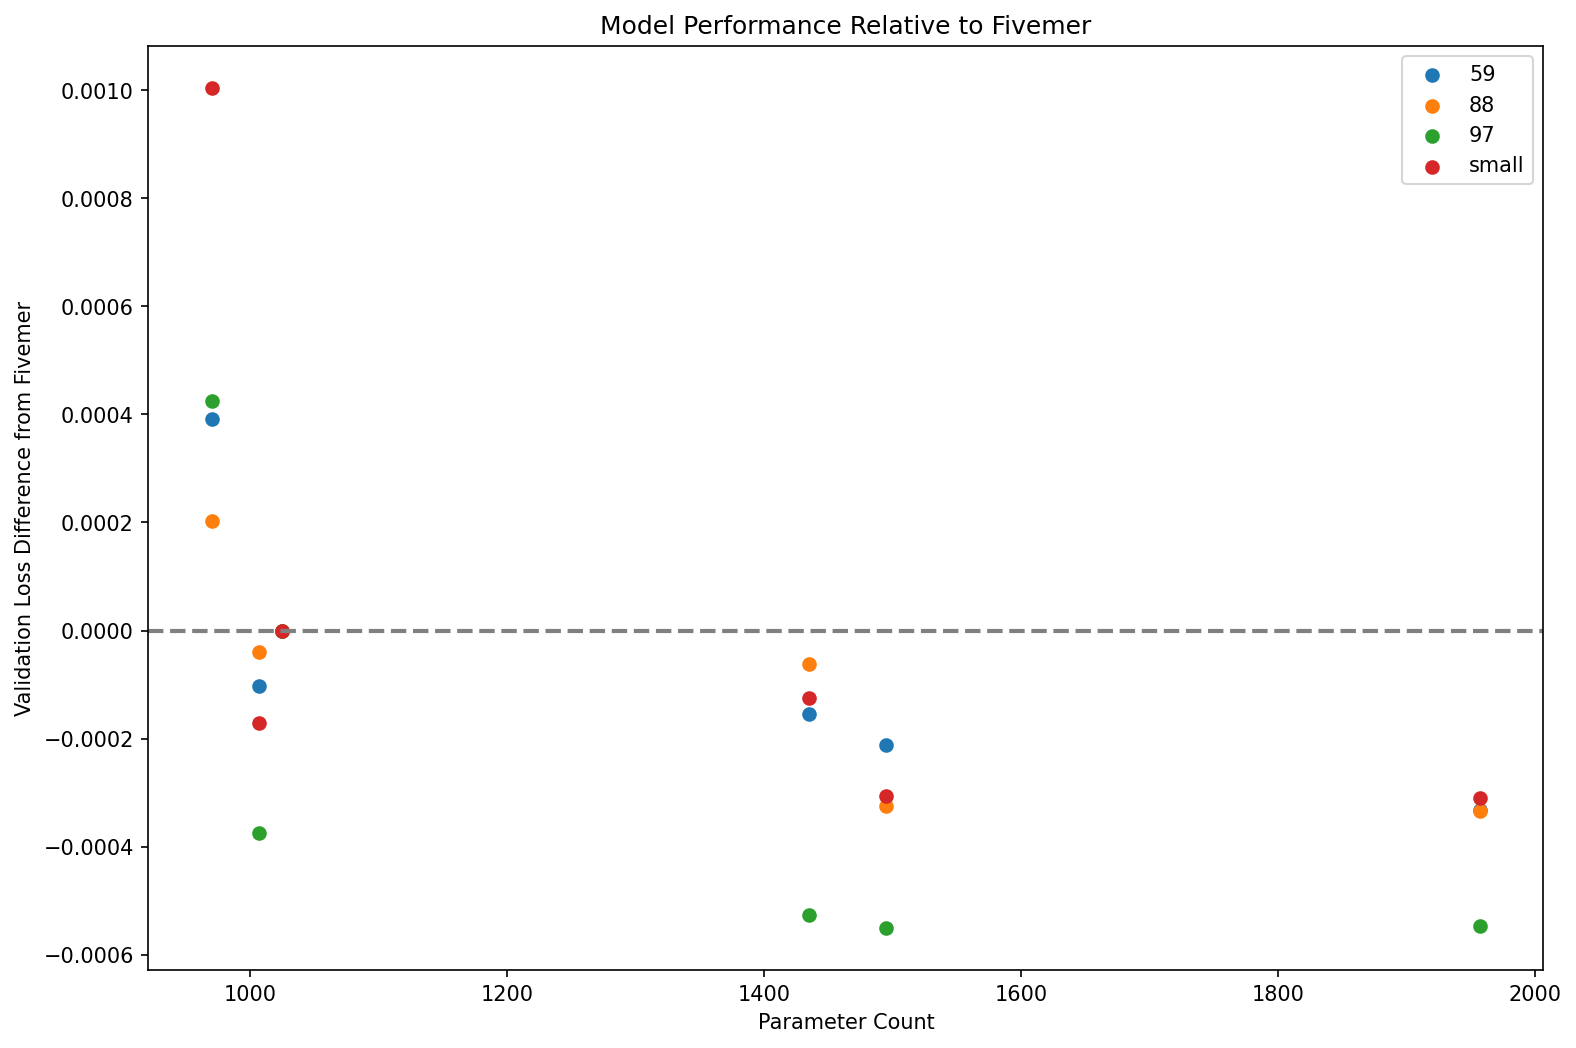

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = final_df

# Calculate the difference in validation loss from the fivemer model
loss_diffs = []
for nickname in df['val_nickname'].unique():
    fivemer_loss = df[(df['model_name'] == 'fivemer') & (df['val_nickname'] == nickname)]['val_loss'].values[0]
    for _, row in df[df['val_nickname'] == nickname].iterrows():
        if row['model'] != 'fivemer':
            diff = row['val_loss'] - fivemer_loss
            loss_diffs.append({'val_nickname': nickname, 'model': row['model_name'], 'parameter_count': row['parameter_count'], 'loss_diff': diff})

# Convert to DataFrame
loss_diff_df = pd.DataFrame(loss_diffs)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
for nickname in loss_diff_df['val_nickname'].unique():
    subset = loss_diff_df[loss_diff_df['val_nickname'] == nickname]
    ax.scatter(subset['parameter_count'], subset['loss_diff'], label=nickname)

ax.set_xlabel('Parameter Count')
ax.set_ylabel('Validation Loss Difference from Fivemer')
ax.set_title('Model Performance Relative to Fivemer')
ax.axhline(0, color='grey', lw=2, linestyle='--')
ax.legend()
plt.show()


/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_27054/2271961537.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['model_name'].map(model_to_xlabel_str), rotation=45, ha="right")


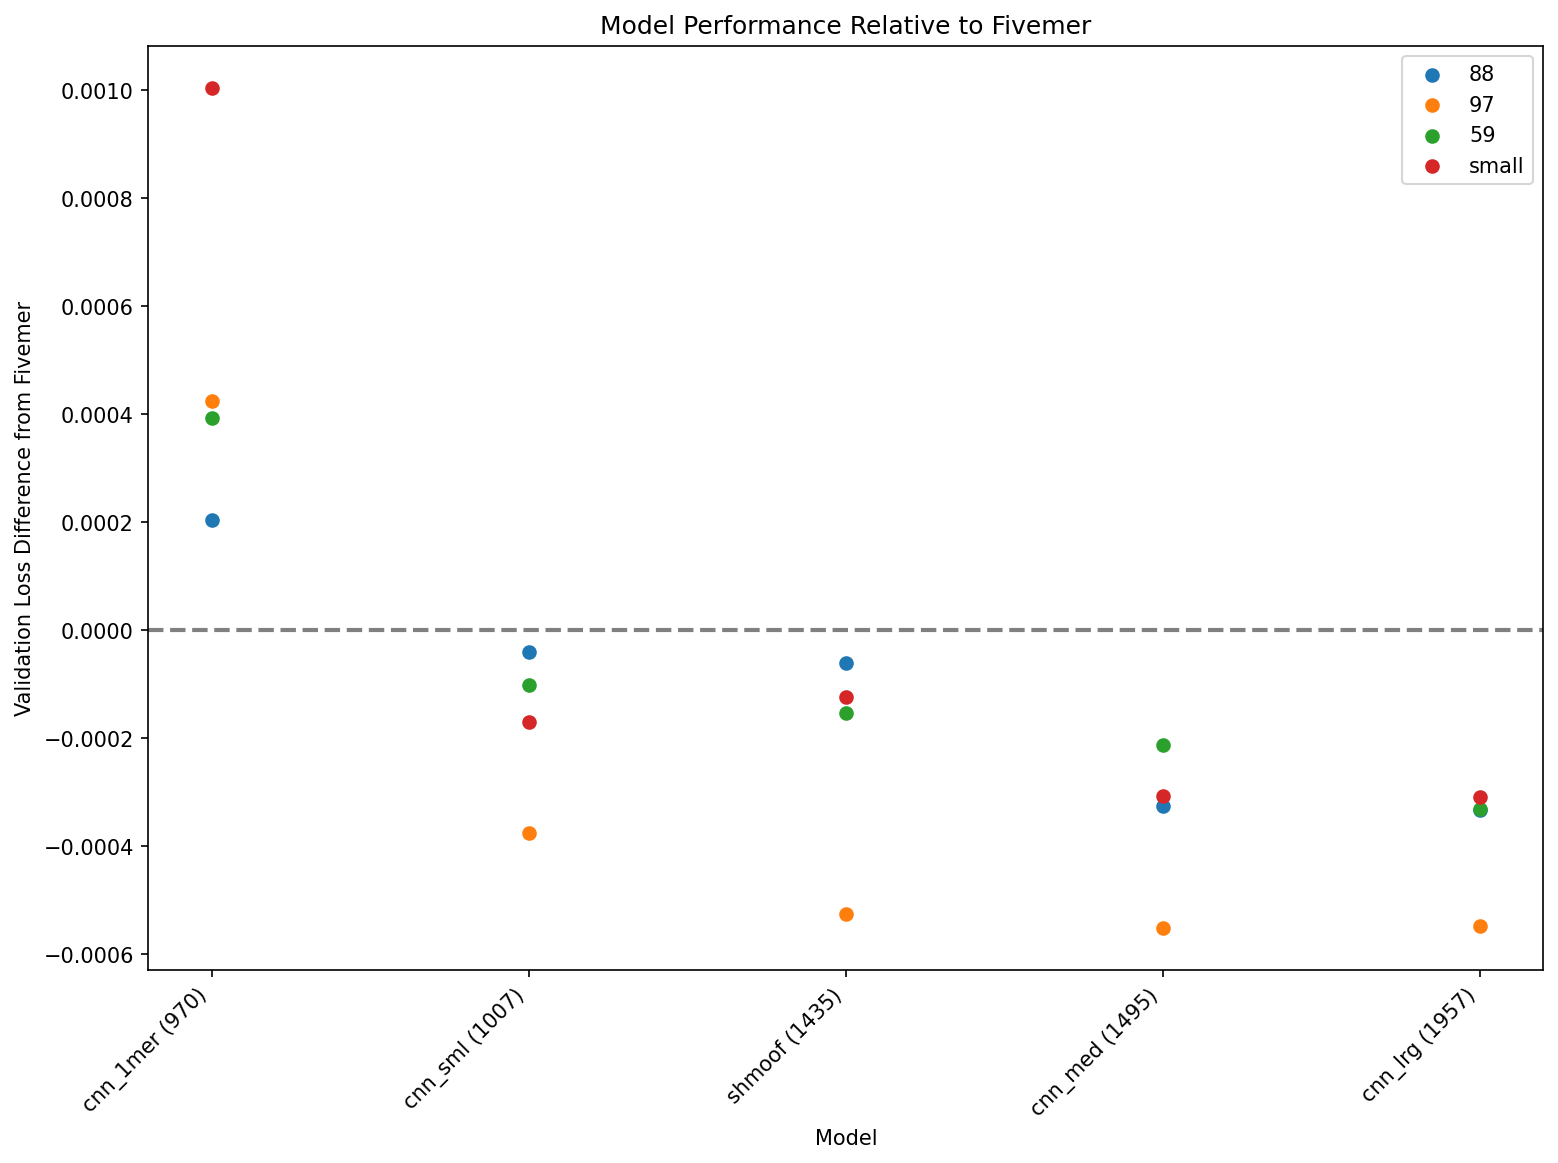

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = final_df 

# Calculate the difference in validation loss from the fivemer model
loss_diffs = []
model_to_xlabel_str = {}
for nickname in df['val_nickname'].unique():
    fivemer_loss = df[(df['model_name'] == 'fivemer') & (df['val_nickname'] == nickname)]['val_loss'].values[0]
    for _, row in df[df['val_nickname'] == nickname].iterrows():
        if row['model_name'] != 'fivemer':
            diff = row['val_loss'] - fivemer_loss
            model_label = f"{row['model_name']} ({row['parameter_count']})"
            model_to_xlabel_str[row['model_name']] = model_label
            loss_diffs.append({'val_nickname': nickname, 'model_name': row['model_name'], 'parameter_count': row['parameter_count'], 'loss_diff': diff})

# Convert to DataFrame and sort by parameter count
loss_diff_df = pd.DataFrame(loss_diffs)
loss_diff_df = loss_diff_df.sort_values(by='parameter_count')

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
for nickname in loss_diff_df['val_nickname'].unique():
    subset = loss_diff_df[loss_diff_df['val_nickname'] == nickname]
    ax.scatter(subset['model_name'], subset['loss_diff'], label=nickname)

ax.set_xlabel('Model')
ax.set_ylabel('Validation Loss Difference from Fivemer')
ax.set_title('Model Performance Relative to Fivemer')
ax.axhline(0, color='grey', lw=2, linestyle='--')
ax.set_xticklabels(subset['model_name'].map(model_to_xlabel_str), rotation=45, ha="right")
ax.legend()
plt.show()


In [8]:
final_df

,val_nickname,model_name,model,parameter_count,val_loss
0,59,cnn_sml,"CNNModel(\n (kmer_embedding): Embedding(65, 6...",1007,0.058132
1,59,cnn_med,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,0.058022
2,59,cnn_lrg,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1957,0.057902
3,59,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.058234
4,59,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1435,0.058080
5,88,cnn_sml,"CNNModel(\n (kmer_embedding): Embedding(65, 6...",1007,0.050669
6,88,cnn_med,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,0.050384
7,88,cnn_lrg,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1957,0.050376
8,88,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.050709
9,88,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1435,0.050648
